Hi there! This is the beggining of a series that's basically a copy of [Jeremy's](https://www.kaggle.com/jhoward) [road to the top](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) series.  

In that Jeremy makes the argument that:
>  You might be surprised to discover that the process of doing this was nearly entirely mechanistic and didn't involve any consideration of the actual data or evaluation details at all.

Well, I don't know anything about identifying whales (although I would find it fun to learn a little bit about it), so let's give it a shot!

---
**Notes:**  
This series is being written by [Lucas](https://twitter.com/lucasgvazquez) and [Francesco](https://twitter.com/Fra_Pochetti), we are going to use "I" instead of "we" just because it's easier, but keep in mind that we say "I" we actually mean "we".  

The notebooks are being published in real time before the series is completed, so at this point we still don't know what final results await us, maybe this will fail completely!

Because the competition is finished, we won't be able to get a placement in the leaderboard :/

## First steps

We'll start by installing and importing required libs (mainly fastai stuff) and getting the data. We'll use [fastkaggle](https://github.com/fastai/fastkaggle), a handy library that will facilitate our life interacting with kaggle, both locally and in their kernels.

In [1]:
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'noaa-right-whale-recognition'
data_dir = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
from fastai.vision.all import *

We're going to be setting a seed to make this notebook easier to reproduce, but don't go crazy about it and try to make all your experiments reproducible, you actually want a bit of variation when experimenting - I just set the seed on the very last moment before I submit to kaggle, when I'm already done with all my experiments.

In [4]:
set_seed(42)

## Exploring the data

Let's take an initial quick look at the data, we have all our images (both train and test) in a single zip file (that we will have to extract), and a `csv` file with the labels. 

In [5]:
imgs_dir = untar_dir(data_dir/'imgs.zip', Path('imgs'))

In [6]:
image_files = get_image_files(imgs_dir)
targs_df = pd.read_csv(data_dir/'train.csv')

Since the task was a bit confusing at first, let me reiterate it and clarify what it is: We're trying to identify which whale appears in each image, categorized by `whaleID` in our dataframe. We are **not** identifying whales by species, but instead whether it's Kayla, Takara, etc.

In [7]:
targs_df.head()

Image      whaleID
0  w_7812.jpg  whale_48813
1  w_4598.jpg  whale_09913
2  w_3828.jpg  whale_45062
3  w_8734.jpg  whale_74162
4  w_3251.jpg  whale_99558

I also always like to take a quick look at some images.

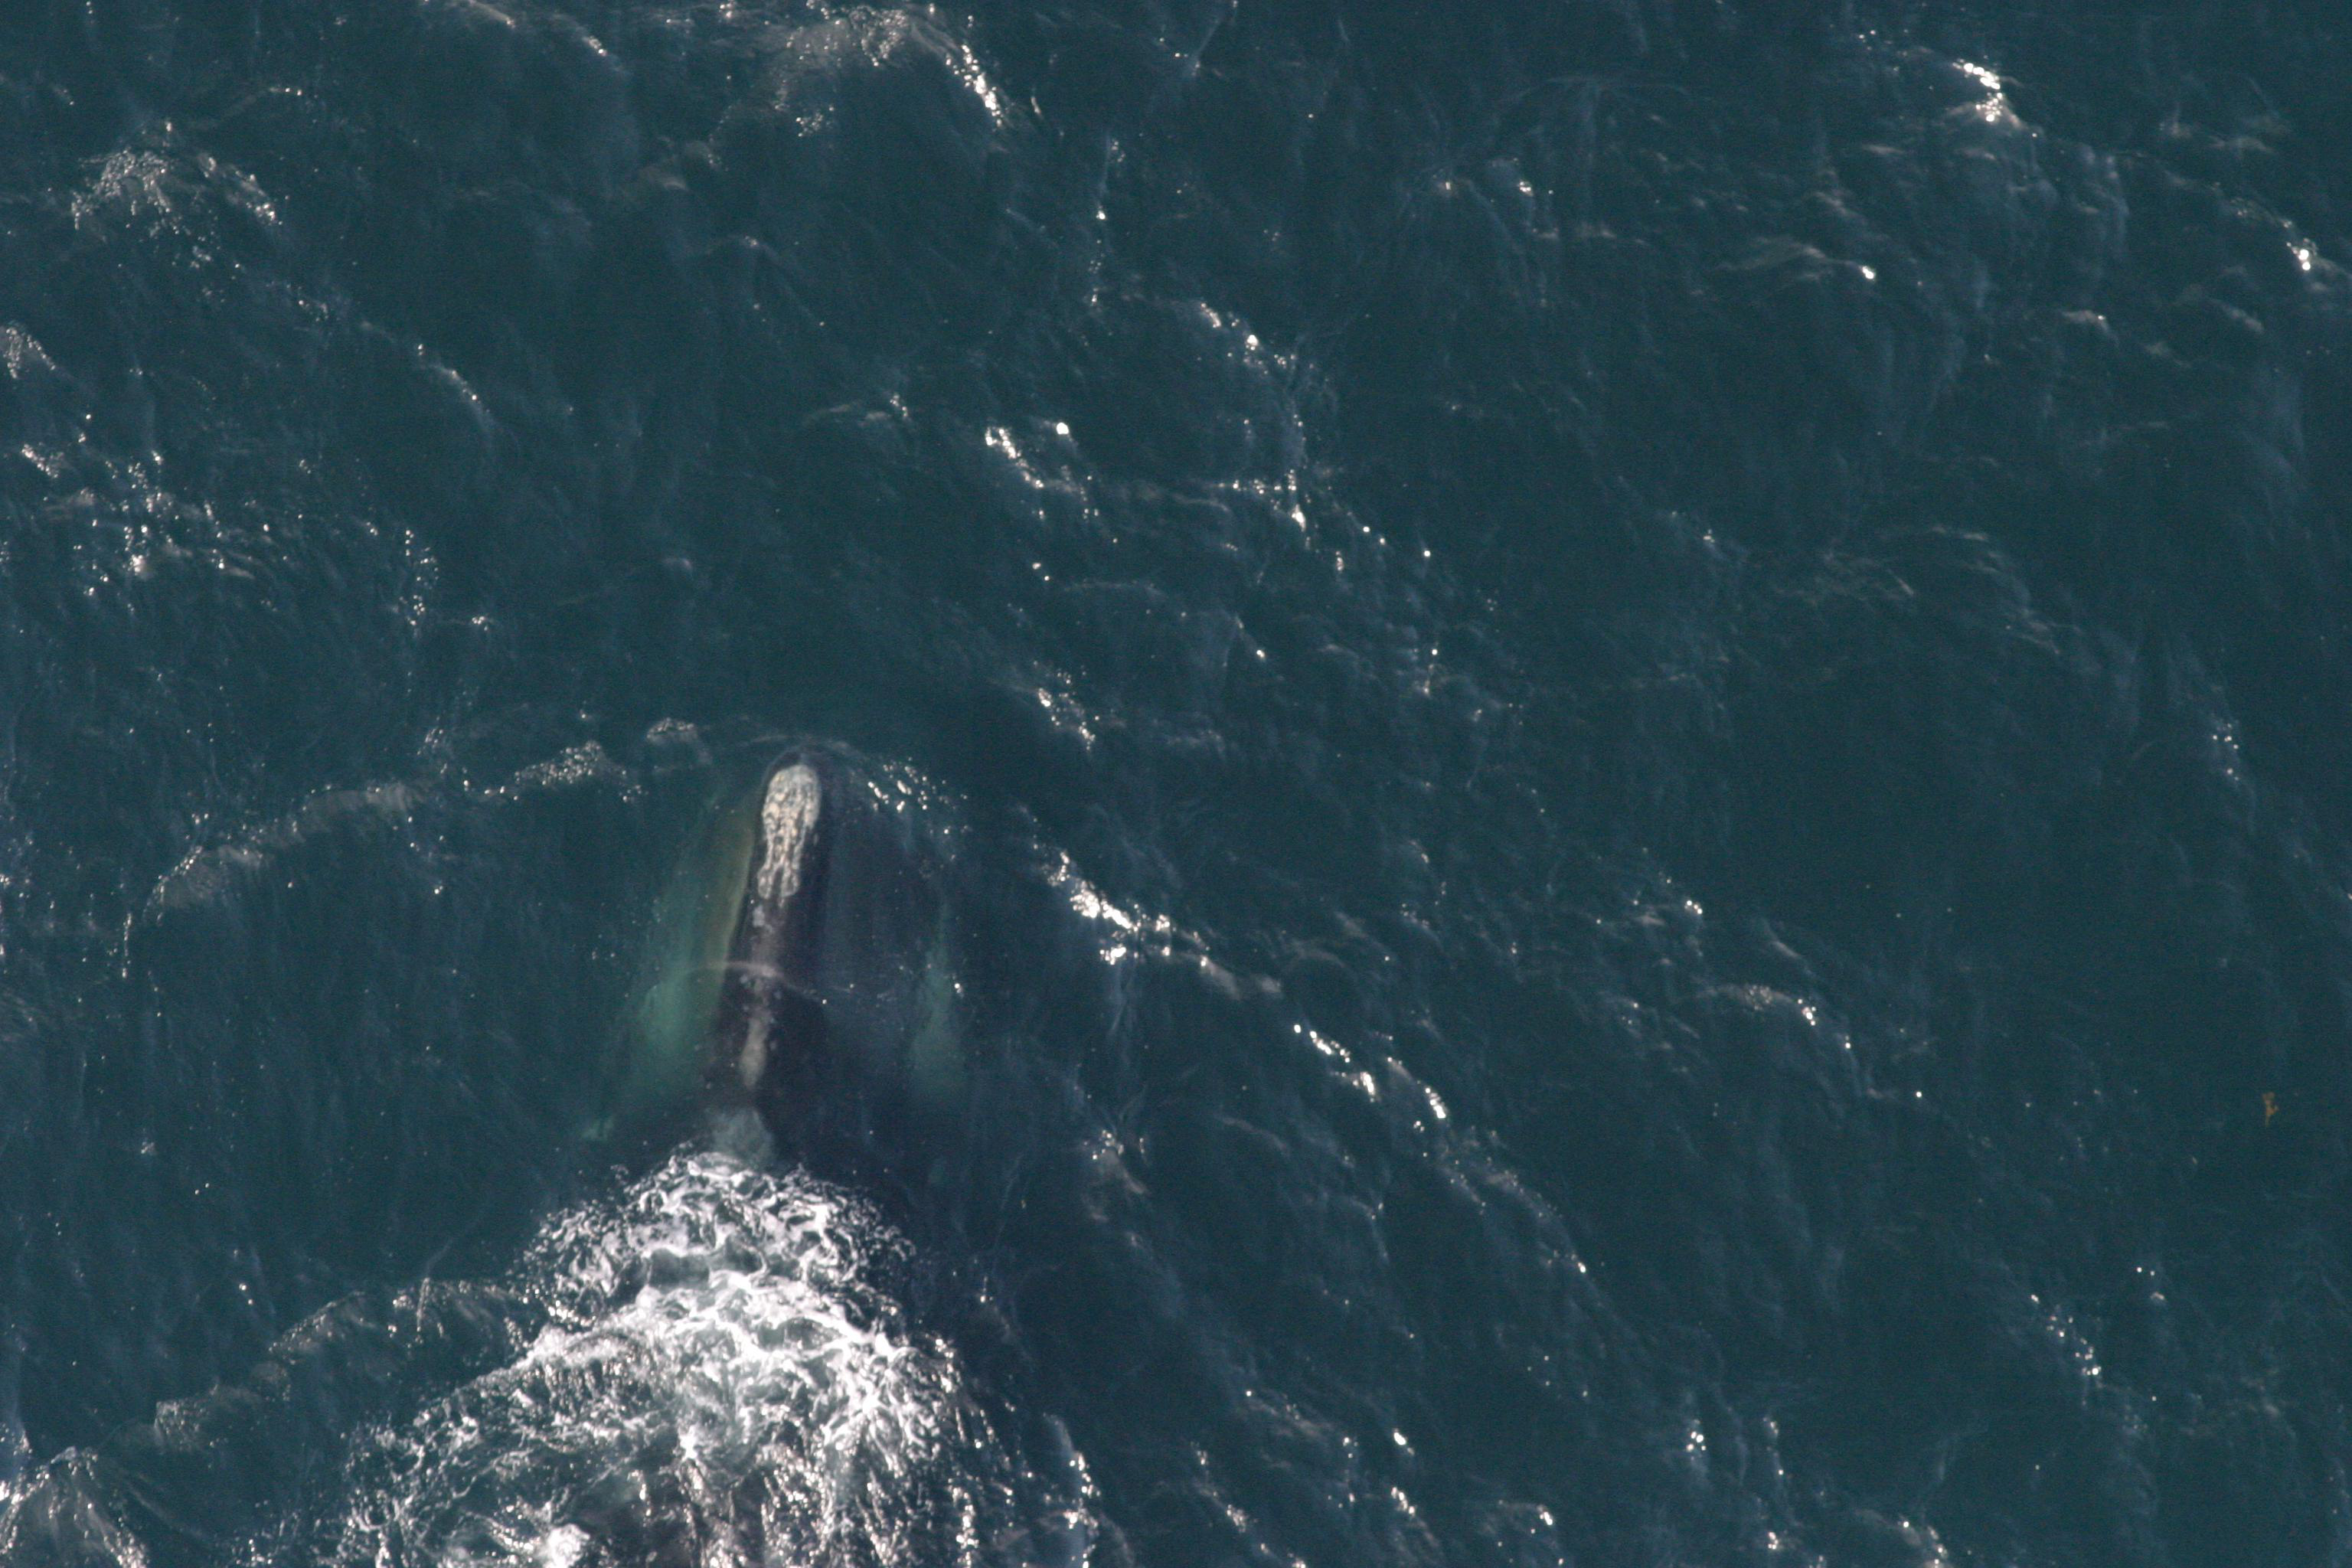

In [8]:
image_file = random.choice(image_files)
PILImage.create(image_file)

Now, while experimenting I found that one of the images specified in the dataframe is not present in the `imgs` folder, so let me already go ahead and remove it.

In [9]:
targs_df = targs_df[targs_df['Image']!='w_7489.jpg']

Let's check how many samples and classes we have and how balanced our data is.

In [10]:
def count_data(df):
    print(f"There are {len(df['whaleID'].unique())} classes and {len(targs_df)} samples.")
    
    whale_count = Counter(targs_df['whaleID'])
    return plt.hist(whale_count.values())

There are 447 classes and 4543 samples.


(array([126., 134.,  76.,  73.,  24.,   8.,   4.,   0.,   0.,   2.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

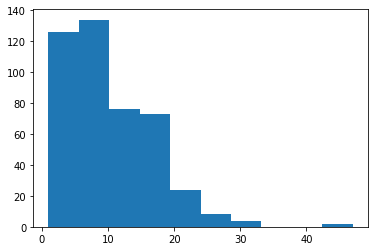

In [11]:
count_data(targs_df)

We can observe that the vast majority of data consists of whales that showed up less than 20 times, with a good amount showing less than 6. That makes our dataset heavily imbalanced, we can simplify and eliminate this problem for now by creating a subset that only contains whales that showed up more than 20 times.

In [12]:
count_above = targs_df['whaleID'].value_counts() > 20
count_above = list(count_above.index[count_above])

mask = targs_df['whaleID'].apply(lambda o: o in count_above)
targs_df = targs_df[mask]

There are 29 classes and 744 samples.


(array([15.,  5.,  3.,  3.,  1.,  0.,  0.,  0.,  1.,  1.]),
 array([21. , 23.6, 26.2, 28.8, 31.4, 34. , 36.6, 39.2, 41.8, 44.4, 47. ]),
 <BarContainer object of 10 artists>)

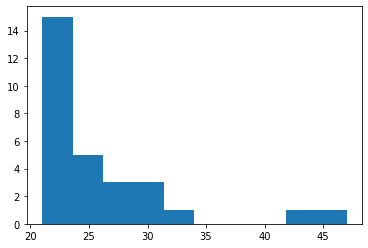

In [13]:
count_data(targs_df)

A bit better but still unbalanced. With 745 samples our models should train extremely quick and we'll be able to iterate fast!

There's a problem though, the resolution of the images is very high and that will bottleneck our training pipeline! (You will notice the GPU will stay at 0% usage for long periods of time).

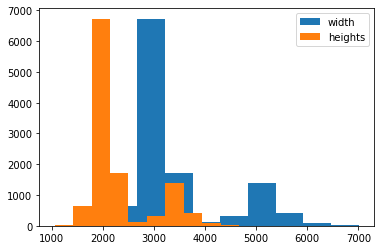

In [14]:
sizes = parallel(image_size, image_files)
widths, heights = zip(*sizes)
plt.hist(widths, label='width')
plt.hist(heights, label='heights')
plt.legend()

We can resize all images to a much smaller size before hand, avoiding overwheling the CPU (which is specially limited in kaggle). Of course `fastai` has a handy function for that; it'll resize all images to a new folder, keeping the original file structure the same.

In [15]:
if not Path('imgs_288max').exists():
    resize_images(imgs_dir, dest='imgs_288max', max_size=288, recurse=True, progress=progress_bar)

## Data pipeline

We are finally ready to build the data pipeline! Most fastai tutorials use the `DataBlock` API but I really like to use the `Datasets` API. It's a tiny bit more verbose, but in my opinion it's so much easier to understand and use (specially when you start doing out of the box stuff).

The first thing we need is something to iterate over to get our image-caption pairs. The most natural approach is to use `image_files`, but in this case, both training and testing files are in the same folder so we would have to write some custom logic to separate them. Instead an easier approach is just to iterate over the rows of our dataframe, which only contain training items.

In [16]:
items = targs_df['Image']
item = items[0]
item

'w_7812.jpg'

We need a way of converting each of those items into an image-caption pair.

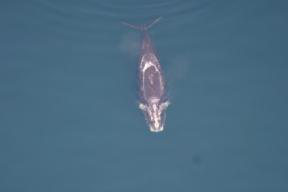

In [17]:
image_file = f'imgs_288max/{item}'
image = PILImage.create(image_file)
image

In [18]:
image2whaleID = {o.Image: o.whaleID for o in targs_df.itertuples()}
label = image2whaleID[item]
label

'whale_48813'

Now we just have to put those into their functions and create a `Dataset`. We will also randomly split our data into train and validation.

In [19]:
def get_image_file(item):
    return f'imgs_288max/{item}'

def get_label(item):
    return image2whaleID[item]

We also have to provide `Categorize` to the label, so it converts the label from a string to a tensor.

In [20]:
x_pipe = [get_image_file, PILImage.create]
y_pipe = [get_label, Categorize()]

splits = RandomSplitter(seed=42)(items)
dss = Datasets(items, [x_pipe, y_pipe], splits=splits)

<AxesSubplot:title={'center':'whale_48813'}>

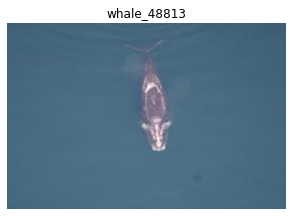

In [21]:
dss.show(dss[0])

Now we can create our dataloader. Before the dataloader is able to create batches, we need to resize the images to one common size. We can do that by passing transforms to `after_item` which executes on an item by item basis, just before a batch is formed.  

After we have our batch, we will apply augmentation transforms. `fastai` provides a bundle of commonly used transforms accessible with `aug_transforms`. The most important parameters to be defined here are:  
1. `min_scale`: randomly crop the images, maintaining atleast `min_scale` percentage of the original image.  
2. `size`: resize the crop to the defined `size`.  

In [22]:
after_item = [ToTensor(), Resize((192, 288))]
after_batch = [IntToFloatTensor(), *aug_transforms(size=(128, 192), min_scale=0.75, flip_vert=True, max_rotate=180)]
dls = dss.dataloaders(32, after_item=after_item, after_batch=after_batch)

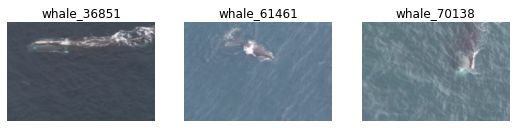

In [23]:
dls.show_batch(max_n=3)

Looks about right! Let's define our metric and train our first model `resnet26d`, as it's the fastest one we can find in [the best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning).

In [24]:
metrics = [error_rate]
learn = vision_learner(dls, 'resnet26d', metrics=metrics).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet26d-69e92c46.pth" to /root/.cache/torch/hub/checkpoints/resnet26d-69e92c46.pth


SuggestedLRs(valley=0.0014454397605732083)

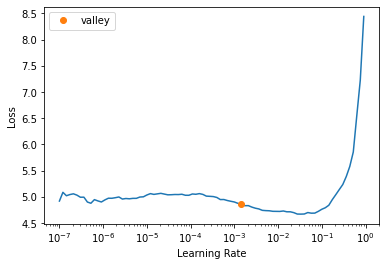

In [25]:
learn.lr_find()

In [26]:
learn.fine_tune(5, 0.002)

Well, that certainly seems horrible! But we don't care right now, we just want to make the first submission as fast as possible!

## Inference

Remember that all our images, train and test are into the same folder? We need a way to get what images are from the test set first of all! For that we can use the sample submission file that comes with the data.

In [27]:
test_df = pd.read_csv(data_dir / 'sample_submission.csv')
test_df.head()

Image  whale_00195  whale_00442  whale_02411  whale_02608  \
0   w_1947.jpg            1            0            0            0   
1  w_11096.jpg            1            0            0            0   
2  w_10973.jpg            1            0            0            0   
3  w_10442.jpg            1            0            0            0   
4  w_10606.jpg            1            0            0            0   

   whale_02839  whale_03103  whale_03227  whale_03623  whale_03728  ...  \
0            0            0            0            0            0  ...   
1            0            0            0            0            0  ...   
2            0            0            0            0            0  ...   
3            0            0            0            0            0  ...   
4            0            0            0            0            0  ...   

   whale_98618  whale_98633  whale_98645  whale_98746  whale_98939  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   whale_98996  whale_99243  whale_99326  whale_99558  whale_99573  
0            0            0            0            0            0  
1            0            0            0            0            0  
2            0            0            0            0            0  
3            0            0            0            0            0  
4            0            0            0            0            0  

[5 rows x 448 columns]

We can then easily create a validation dataloader with fastai and predict!

In [28]:
test_items = test_df['Image']
test_dl = learn.dls.test_dl(test_items)

In [29]:
preds, targs = learn.get_preds(dl=test_dl)

In [30]:
df = pd.DataFrame(preds.numpy(), columns=learn.dls.vocab)
df["Image"] = test_items
df.head()

whale_03227  whale_08017  whale_17604  whale_24458  whale_26288  \
0     0.001803     0.305308     0.058440     0.010400     0.034355   
1     0.007437     0.001213     0.277710     0.001869     0.102364   
2     0.023262     0.002283     0.055967     0.044101     0.010635   
3     0.043270     0.007963     0.000630     0.009676     0.000438   
4     0.025750     0.045370     0.010472     0.522284     0.013874   

   whale_28892  whale_34656  whale_36851  whale_38681  whale_48813  ...  \
0     0.007796     0.004491     0.005328     0.027551     0.000656  ...   
1     0.025806     0.016379     0.045246     0.010574     0.004334  ...   
2     0.000404     0.022746     0.013209     0.011440     0.030787  ...   
3     0.000247     0.170968     0.055181     0.010999     0.179173  ...   
4     0.000900     0.004397     0.039572     0.000673     0.067578  ...   

   whale_78280  whale_79823  whale_85464  whale_87291  whale_87604  \
0     0.128520     0.033461     0.006326     0.005567     0.021583   
1     0.004797     0.003469     0.000092     0.001327     0.008678   
2     0.000517     0.002988     0.135840     0.003029     0.194963   
3     0.003545     0.001910     0.337364     0.001194     0.042766   
4     0.001745     0.013905     0.000181     0.004272     0.003620   

   whale_89615  whale_90957  whale_95091  whale_95370        Image  
0     0.016916     0.001134     0.001095     0.164701   w_1947.jpg  
1     0.067724     0.095041     0.017296     0.068056  w_11096.jpg  
2     0.011547     0.003974     0.000172     0.043715  w_10973.jpg  
3     0.000206     0.000458     0.001271     0.001578  w_10442.jpg  
4     0.036527     0.005200     0.009623     0.001155  w_10606.jpg  

[5 rows x 30 columns]

Now, a problem left to fix is: we removed a bunch of classes from our dataset, which we now have to add back in. Let's give all of the removed classes a probability of 0.

We're going to use the columns of the sample submission file to know all the whaleIDs, and subtract that from our learner vocab to get all classes we excluded.

In [31]:
full_vocab = list(test_df.columns[1:])

In [32]:
diff_vocab = set(full_vocab) - set(learn.dls.vocab)
for cat in diff_vocab:
    df[cat] = 0.0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
def submit(df):
    preds_path = 'first-submission.csv'
    df.to_csv(preds_path, index=False)
    if not iskaggle:
        from kaggle import api
        api.competition_submit_cli(preds_path, 'resnet26d >20whales', comp)

In [34]:
submit(df)

Whelp, that got us a score of `30.29923`, putting us around at rank 248 out of 364 participants. That's, well, horrible.... Let's find out how horrible this is by trying a uniform guess of 1 for every whale.

In [35]:
diff_vocab = set(full_vocab) - set(learn.dls.vocab)
for cat in full_vocab:
    df[cat] = 1.0

In [36]:
submit(df)

That improves the score to 6.10255!

All this work we had, just to be heavily outclassed by a uniform (random) guess!!! (╯°□°）╯︵ ┻━┻

We've excluded 418 of classes from our dataset, so very likely that's a reason of this extremely poor performance. Next time we can try training a model with the complete dataset, and see if that is better than random guessing.

## Lessons learned

Even though I said in the beggining "let's just take a quick look at the dataset and get to the modelling step asap", I think I still spent too much time into over-engineering solutions to simplify the problem, only to get burnt at the end.

Next time, just really try harder to get to training models, doing absolutely nothing more than the necessary to get there.